# EV Low-SOC Charging Behavior Prediction
Includes strict datetime parsing, error checks, and robust feature extraction.


In [ ]:
# Step 1: Install required libraries
# !pip install xgboost shap pandas matplotlib scikit-learn -q

In [ ]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Step 3: Upload dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('combined_ev_behavior.csv')
df.head()

Saving combined_ev_behavior.csv to combined_ev_behavior.csv


,vehicle_id,trip_start_time,trip_end_time,soc_end,trip_distance,next_charge_time,charged_immediately
0,EV_07271,2023-11-03 12:33:00,2023-11-03 12:56:55.563022,0.137,13.33,2023-11-03 17:07:55.563022,0
1,EV_00861,2023-12-15 10:08:00,2023-12-15 10:31:00.436975,0.151,14.38,2023-12-15 10:36:00.436975,1
2,EV_05391,2023-11-22 06:24:00,2023-11-22 06:41:34.514930,0.163,12.40,2023-11-22 10:08:34.514930,0
3,EV_05192,2023-11-04 14:24:00,2023-11-04 15:04:50.036656,0.508,27.19,2023-11-04 18:26:50.036656,0
4,EV_05735,2023-11-03 08:50:00,2023-11-03 09:08:02.951256,0.467,7.93,2023-11-03 09:46:02.951256,1


In [ ]:
# Step 4: Parse datetime columns and validate
df['trip_start_time'] = pd.to_datetime(df['trip_start_time'], errors='coerce')
df['trip_end_time'] = pd.to_datetime(df['trip_end_time'], errors='coerce')
df['next_charge_time'] = pd.to_datetime(df['next_charge_time'], errors='coerce')

print('Unparsed trip_start_time:', df['trip_start_time'].isna().sum())
print('Unparsed trip_end_time:', df['trip_end_time'].isna().sum())
print('Unparsed next_charge_time:', df['next_charge_time'].isna().sum())

# Remove rows with invalid datetime
df.dropna(subset=['trip_start_time', 'trip_end_time', 'next_charge_time'], inplace=True)
df.reset_index(drop=True, inplace=True)

🕒 Unparsed trip_start_time: 0
🕒 Unparsed trip_end_time: 0
🕒 Unparsed next_charge_time: 0


In [ ]:
# Step 5: Feature engineering
df['hour_of_day'] = df['trip_end_time'].dt.hour
df['day_of_week'] = df['trip_end_time'].dt.weekday + 1
df['days_since_last_charge'] = (df['trip_start_time'] - df['next_charge_time']).dt.days.abs()
df.head()

,vehicle_id,trip_start_time,trip_end_time,soc_end,trip_distance,next_charge_time,charged_immediately,hour_of_day,day_of_week,days_since_last_charge
0,EV_07271,2023-11-03 12:33:00,2023-11-03 12:56:55.563022,0.137,13.33,2023-11-03 17:07:55.563022,0,12,5,1
1,EV_00861,2023-12-15 10:08:00,2023-12-15 10:31:00.436975,0.151,14.38,2023-12-15 10:36:00.436975,1,10,5,1
2,EV_05391,2023-11-22 06:24:00,2023-11-22 06:41:34.514930,0.163,12.40,2023-11-22 10:08:34.514930,0,6,3,1
3,EV_05192,2023-11-04 14:24:00,2023-11-04 15:04:50.036656,0.508,27.19,2023-11-04 18:26:50.036656,0,15,6,1
4,EV_05735,2023-11-03 08:50:00,2023-11-03 09:08:02.951256,0.467,7.93,2023-11-03 09:46:02.951256,1,9,5,1


## 🔍 Exploratory Data Analysis (EDA)
In this section, we explore the structure, distribution, and key patterns in the dataset.

<ipython-input-6-3412202811>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='charged_immediately', data=df, palette='Set2')


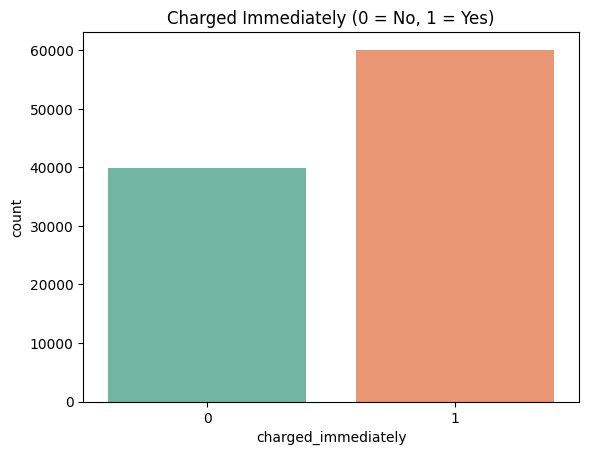

In [ ]:
# 🧮 Target Variable Distribution
sns.countplot(x='charged_immediately', data=df, palette='Set2')
plt.title('Charged Immediately (0 = No, 1 = Yes)')
plt.show()

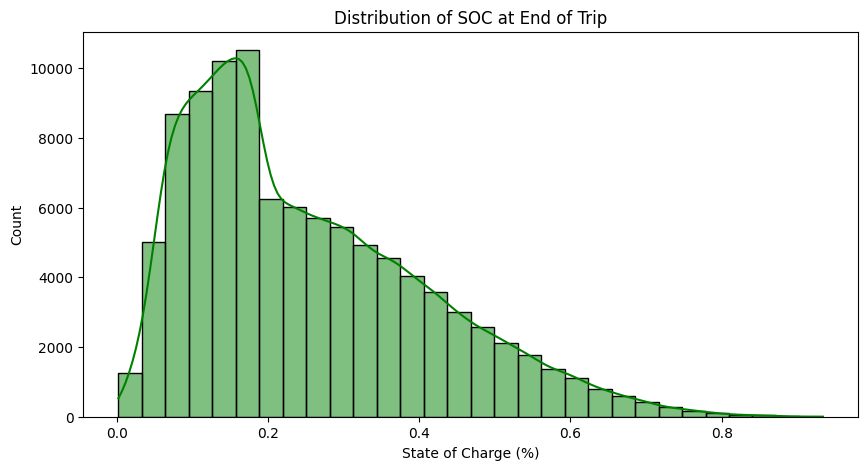

In [ ]:
# 🔋 SOC Distribution
plt.figure(figsize=(10,5))
sns.histplot(df['soc_end'], kde=True, bins=30, color='green')
plt.title('Distribution of SOC at End of Trip')
plt.xlabel('State of Charge (%)')
plt.show()

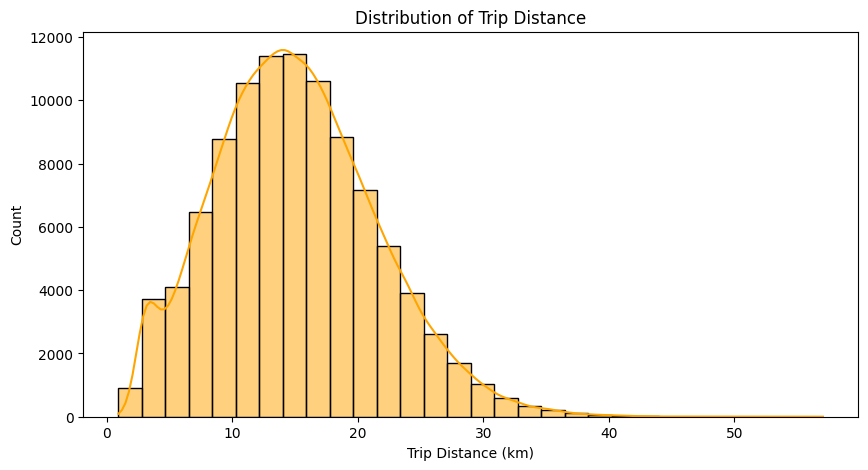

In [ ]:
# 🛣️ Trip Distance Distribution
plt.figure(figsize=(10,5))
sns.histplot(df['trip_distance'], kde=True, bins=30, color='orange')
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (km)')
plt.show()

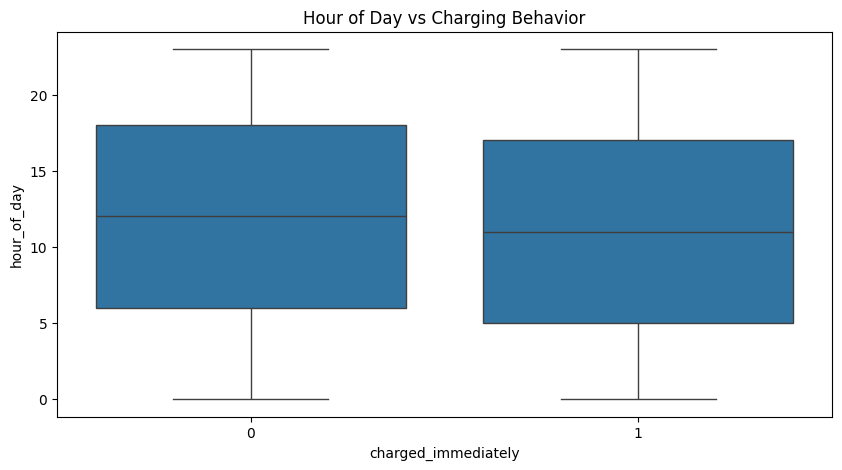

In [ ]:
# 🕐 Hourly Pattern by Charging Behavior
plt.figure(figsize=(10,5))
sns.boxplot(x='charged_immediately', y='hour_of_day', data=df)
plt.title('Hour of Day vs Charging Behavior')
plt.show()

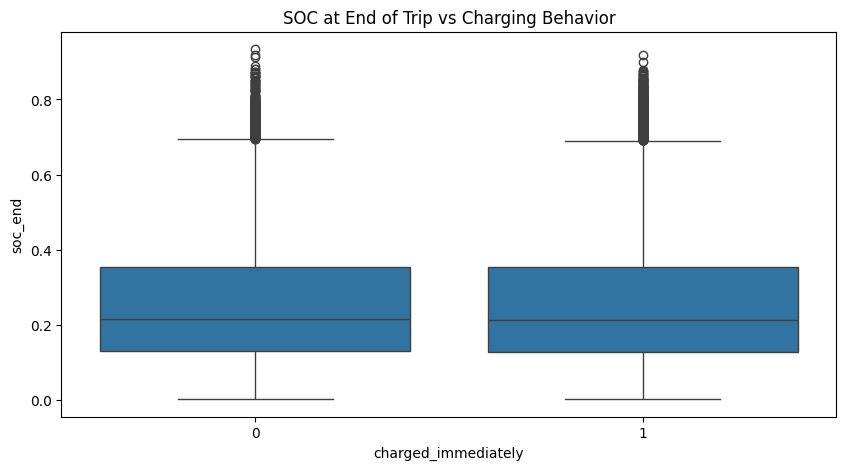

In [ ]:
# 🔋 SOC vs Charging Behavior
plt.figure(figsize=(10,5))
sns.boxplot(x='charged_immediately', y='soc_end', data=df)
plt.title('SOC at End of Trip vs Charging Behavior')
plt.show()

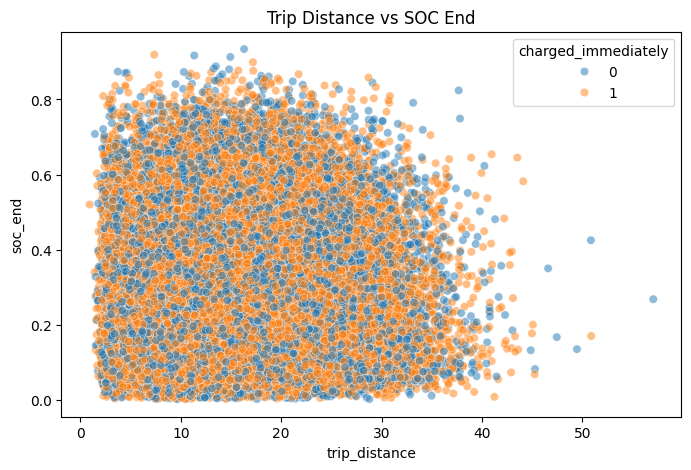

In [ ]:
# 🧭 Trip Distance vs SOC (Scatter)
plt.figure(figsize=(8,5))
sns.scatterplot(x='trip_distance', y='soc_end', hue='charged_immediately', data=df, alpha=0.5)
plt.title('Trip Distance vs SOC End')
plt.show()

<ipython-input-12-3638803061>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour_of_day', data=df, palette='Blues')


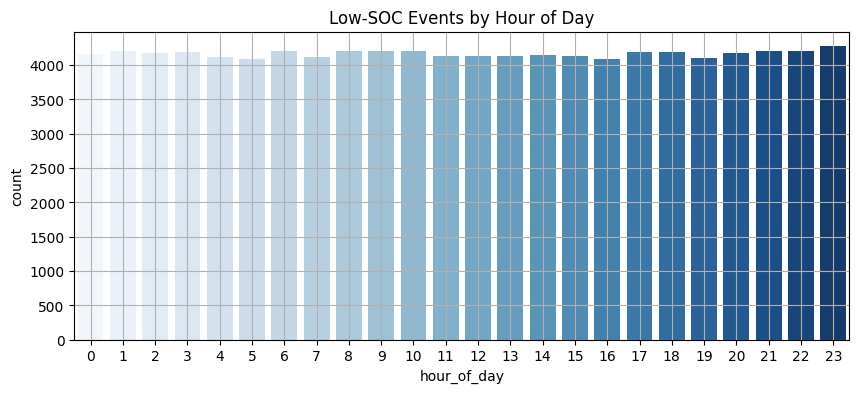

In [ ]:
# Step 6: Visualization - Hour distribution
plt.figure(figsize=(10,4))
sns.countplot(x='hour_of_day', data=df, palette='Blues')
plt.title('Low-SOC Events by Hour of Day')
plt.grid(True)
plt.show()

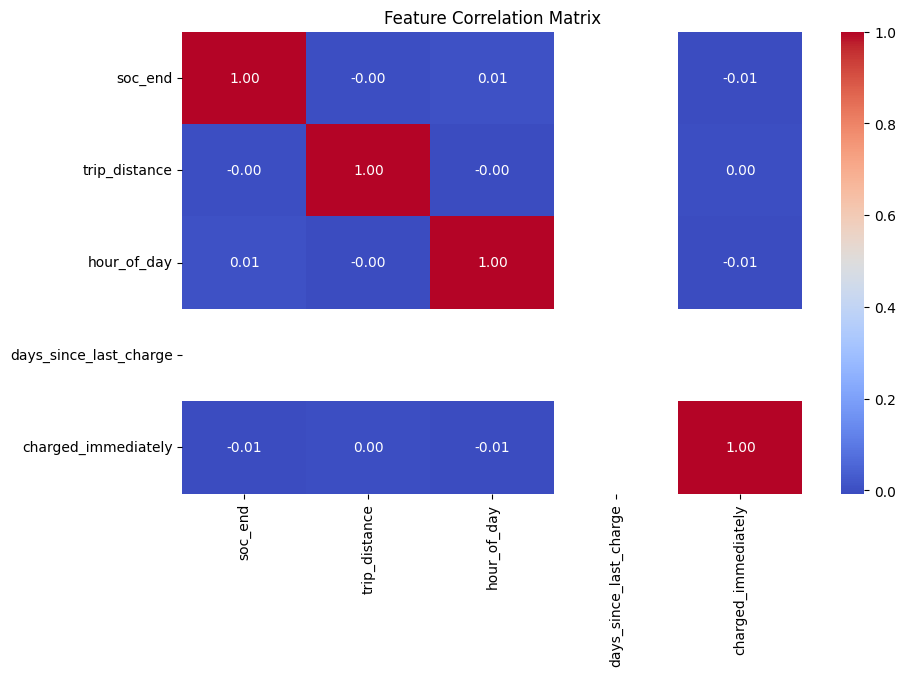

In [ ]:
# Step 7: Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[['soc_end', 'trip_distance', 'hour_of_day', 'days_since_last_charge', 'charged_immediately']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Step 8: Prepare data for model
features = ['soc_end', 'trip_distance', 'hour_of_day', 'day_of_week', 'days_since_last_charge']
X = df[features]
y = df['charged_immediately']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Step 9: Train XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.1, 'max_depth': 6}
model = xgb.train(params, dtrain, num_boost_round=100)

Accuracy: 0.5982333333333333
F1 Score: 0.7467378285810342
ROC AUC: 0.4999837466238906


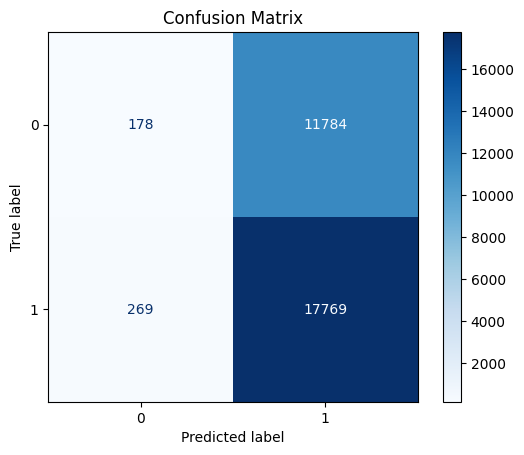

In [ ]:
# Step 10: Evaluate model
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob >= 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

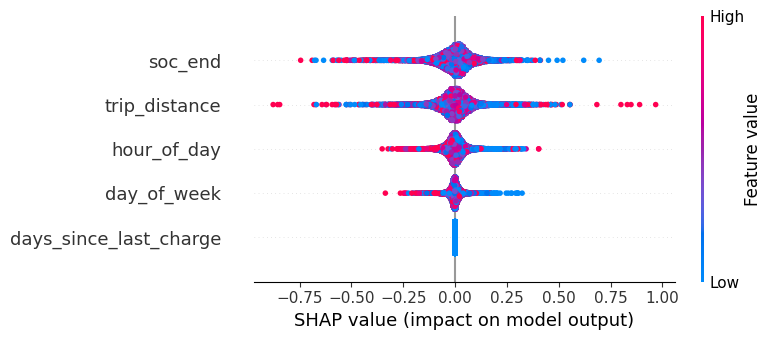

In [ ]:
# Step 11: SHAP explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)